# stk Workshop

by: Steven Bennett and Andrew Tarzia

### Update 25/02/24

Installation of py3Dmol using `pip install py3Dmol` is required.

*This code requires some prepared .mol files, which are not with the repository!*

# Install conda env!

# Imports 

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem 
from rdkit.Chem import AllChem as rdkit
from collections import defaultdict
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom
IPythonConsole.ipython_3d = True

import py3Dmol
from IPython.display import Image
import matplotlib.pyplot as plt
import subprocess
import time
import stk
import stko

# Some useful functions 

In [2]:
def show_stk_mol(stk_mol):
    data = rdkit.MolToMolBlock(stk_mol.to_rdkit_mol())
    p = py3Dmol.view(
        data=data,
        style={'stick':{'colorscheme':'cyanCarbon'}}, 
        width=400,
        height=400,
    )
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    p.show()

# What is in a Molecule? 

In [3]:
stk.Molecule  # Do not use me.
stk.BuildingBlock  # Use me to make
stk.ConstructedMolecule # me.

stk._internal.constructed_molecule.ConstructedMolecule

In [4]:
# Defining 
molecule = stk.BuildingBlock('C1C(=C)CC(C)CCC1=C')  # Uses ETKDG!!!!!! Be aware.
# molecule = stk.BuildingBlock.init_from_file('.mol') # What
# molecule = stk.BuildingBlock.init_from_file('.sdf') # Do you
# molecule = stk.BuildingBlock.init_from_file('.pdb') # Notice?
# molecule = stk.BuildingBlock.init_from_molecule(molecule)  # stk.Molecule
# molecule = stk.BuildingBlock.init_from_rdkit_mol(rdkit_molecule)

In [5]:
show_stk_mol(molecule)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

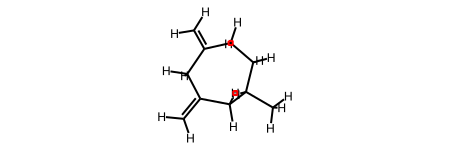

In [6]:
molecule.to_rdkit_mol()

In [7]:
# Writing
molecule.write('.mol/.sdf/.pdb/.xyz')
rdkit_molecule = molecule.to_rdkit_mol()
# New things - much more versatile.
stk.XyzWriter().write(molecule, path)  
stk.MolWriter().write(molecule, path)
stk.PdbWriter().write(molecule, path)
stk.TurbomoleWriter().write(molecule, path)

KeyError: ''

## A short detour: how do you visualize your molecules?
* pymol for anything non periodic (although it is possible) - makes good images, a bit of a pain to use - SO MANY MOLECULES
* avogadro for anything - slow and buggy on nonlinux, very versatile and good for editting - one molecule at atime
* ovito - .pdb or .xyz, good analysis and visualisation options, so many molecules, AUTO REFRESH!
* ase - one molecule at time
* rdkit - small molecules with bond topology
* py3dmol - jupyter notebook env (thumbs down for me) 

In [8]:
molecule

BuildingBlock('C=C1CCC(C)CC(=C)C1', ())

In [9]:
# Immutability and what it means for you.
new_molecule = molecule.with_structure_from_file('file')
NOT
molecule.with_structure_from_file('file')

# Look for with methods ---->>>

KeyError: ''

# Our own chemistry example 
https://pubs.acs.org/doi/10.1021/acs.inorgchem.0c02682

In [10]:
mol = stk.BuildingBlock.init_from_file('one_i_prepared_earlier.mol')
show_stk_mol(mol)

OSError: Bad input file one_i_prepared_earlier.mol

### Issues much?
* Manually drawing things in avogadro that are complex is a pain
* loading in metal containing species is not straightforward because RDKit requires dative bond definitions

In [11]:
cu_atom_green = stk.BuildingBlock(
    smiles='[Cu+2]',
    functional_groups=(
        stk.SingleAtom(stk.Cu(0, charge=2))
        for i in range(4)
    ),
    position_matrix=[[0, 0, 0]],
)
cu_atom_orange = stk.BuildingBlock(
    smiles='[Cu+2]',
    functional_groups=(
        stk.SingleAtom(stk.Cu(0, charge=2))
        for i in range(2)
    ),
    position_matrix=[[0, 0, 0]],
)

In [12]:
cu_atom_green

BuildingBlock('[Cu+2]', (SingleAtom(Cu(0, charge=2)), SingleAtom(Cu(0, charge=2)), SingleAtom(Cu(0, charge=2)), SingleAtom(Cu(0, charge=2))))

In [13]:
cu_atom_orange

BuildingBlock('[Cu+2]', (SingleAtom(Cu(0, charge=2)), SingleAtom(Cu(0, charge=2))))

In [14]:
dabco = stk.BuildingBlock(
    smiles='C1CN2CCN1CC2',
    functional_groups=[],
)
show_stk_mol(dabco)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

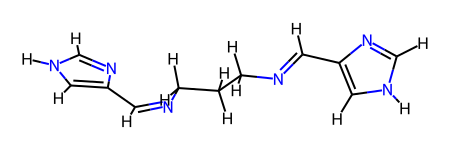

In [15]:
corner_organic = stk.BuildingBlock(
    smiles='C(CN=Cc1c[nH]cn1)CN=Cc2c[nH]cn2',
    functional_groups=[],
)
corner_organic.to_rdkit_mol()

In [16]:
imine_fg = stk.SmartsFunctionalGroupFactory(
    smarts='[#6X3]=[#7X2][#6X4]',
    bonders=(1, ),
    deleters=(),
)
imidazole_fg = stk.SmartsFunctionalGroupFactory(
    smarts='[#6X3][#7X2][#6X3]',
    bonders=(1, ),
    deleters=(),
)

In [17]:
import numpy as np
def get_dihedral(pt1, pt2, pt3, pt4):
    """
    Calculate the dihedral between four points.

    Uses Praxeolitic formula --> 1 sqrt, 1 cross product

    Output in range (-pi to pi).

    From: https://stackoverflow.com/questions/20305272/
    dihedral-torsion-angle-from-four-points-in-cartesian-
    coordinates-in-python
    (new_dihedral(p))

    """

    p0 = np.asarray(pt1)
    p1 = np.asarray(pt2)
    p2 = np.asarray(pt3)
    p3 = np.asarray(pt4)

    b0 = -1.0 * (p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    # normalize b1 so that it does not influence magnitude of vector
    # rejections that come next
    b1 /= np.linalg.norm(b1)

    # vector rejections
    # v = projection of b0 onto plane perpendicular to b1
    #   = b0 minus component that aligns with b1
    # w = projection of b2 onto plane perpendicular to b1
    #   = b2 minus component that aligns with b1
    v = b0 - np.dot(b0, b1) * b1
    w = b2 - np.dot(b2, b1) * b1

    # angle between v and w in a plane is the torsion angle
    # v and w may not be normalized but that's fine since tan is y/x
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    return np.degrees(np.arctan2(y, x))

In [18]:
def build_conformers(mol, N, ETKDG_version=None):
    """
    Convert stk mol into RDKit mol with N conformers.

    ETKDG_version allows the user to pick their choice of ETKDG params.

    `None` provides the settings used in ligand_combiner and unsymm.

    Other options:
        `v3`:
            New version from DOI: 10.1021/acs.jcim.0c00025
            with improved handling of macrocycles.

    """
    molecule = mol.to_rdkit_mol()
    molecule.RemoveAllConformers()

    if ETKDG_version is None:
        cids = rdkit.EmbedMultipleConfs(
            mol=molecule,
            numConfs=N,
            randomSeed=1000,
            useExpTorsionAnglePrefs=True,
            useBasicKnowledge=True,
            numThreads=4,
        )

    elif ETKDG_version == 'v3':
        params = rdkit.ETKDGv3()
        params.randomSeed = 1000
        cids = rdkit.EmbedMultipleConfs(
            mol=molecule,
            numConfs=N,
            params=params
        )

    print(f'there are {molecule.GetNumConformers()} conformers')
    return cids, molecule

In [19]:

def update_from_rdkit_conf(stk_mol, rdk_mol, conf_id):
    """
    Update the structure to match `conf_id` of `mol`.

    Parameters
    ----------
    struct : :class:`stk.Molecule`
        The molecule whoce coordinates are to be updated.

    mol : :class:`rdkit.Mol`
        The :mod:`rdkit` molecule to use for the structure update.

    conf_id : :class:`int`
        The conformer ID of the `mol` to update from.

    Returns
    -------
    :class:`.Molecule`
        The molecule.

    """

    pos_mat = rdk_mol.GetConformer(id=conf_id).GetPositions()
    return stk_mol.with_position_matrix(pos_mat)

In [20]:
# We want to find a conformer that has the 4 Ns atoms that bind to the Cu in a planar conformation
# Find the four N atoms we want.
corner_organic = stk.BuildingBlock(
    smiles='C(CN=Cc1c[nH]cn1)CN=Cc2c[nH]cn2',
    functional_groups=[imine_fg, imidazole_fg],
)
print(corner_organic)

# N-N-N-N dihedral to be 0.
atom_ids = [16, 10, 2, 8]
# Get a conformer ensemble.
cids, confs = build_conformers(corner_organic, N=100)
dihedrals = []
min_dihedral = 180
for cid in cids:
    new_conf = update_from_rdkit_conf(corner_organic, confs, cid)
    position_matrix = new_conf.get_position_matrix()
    dihedral = get_dihedral(
        pt1=position_matrix[atom_ids[0]],
        pt2=position_matrix[atom_ids[1]],
        pt3=position_matrix[atom_ids[2]],
        pt4=position_matrix[atom_ids[3]],
    )
    dihedrals.append(dihedral)
    if abs(dihedral) < min_dihedral:
        corner_organic = corner_organic.with_position_matrix(position_matrix)
    min_dihedral = min([dihedral, min_dihedral])

BuildingBlock('C(=NCCCN=Cc1c[nH]cn1)c1c[nH]cn1', (GenericFunctionalGroup(atoms=(C(3), N(2), C(1)), bonders=(N(2),), deleters=()), GenericFunctionalGroup(atoms=(C(11), N(10), C(9)), bonders=(N(10),), deleters=()), GenericFunctionalGroup(atoms=(C(4), N(8), C(7)), bonders=(N(8),), deleters=()), GenericFunctionalGroup(atoms=(C(12), N(16), C(15)), bonders=(N(16),), deleters=())))
there are 100 conformers


In [21]:
corner_organic

BuildingBlock('C(=NCCCN=Cc1c[nH]cn1)c1c[nH]cn1', (GenericFunctionalGroup(atoms=(C(3), N(2), C(1)), bonders=(N(2),), deleters=()), GenericFunctionalGroup(atoms=(C(11), N(10), C(9)), bonders=(N(10),), deleters=()), GenericFunctionalGroup(atoms=(C(4), N(8), C(7)), bonders=(N(8),), deleters=()), GenericFunctionalGroup(atoms=(C(12), N(16), C(15)), bonders=(N(16),), deleters=())))

In [22]:
dihedrals

[-41.81643397059032,
 13.483584654621415,
 121.1925158344604,
 -68.03530192898388,
 143.83480952315355,
 86.80803455744523,
 179.90175461292256,
 -62.59221158642561,
 156.11550381867707,
 -162.45593823204806,
 170.31768505699705,
 -2.3552576169259667,
 1.284304935811833,
 108.36245934543767,
 58.51823115593111,
 -177.02119246778298,
 18.794104602333817,
 87.24037994314212,
 68.32328706349757,
 -56.060730977564894,
 -105.23957421343603,
 171.76076279221462,
 -90.27394252656715,
 179.34066032855887,
 -26.518515950685014,
 125.63543041888843,
 158.0795728925846,
 -5.179797269234725,
 125.80866426208243,
 178.25125362139678,
 -94.53716824699232,
 -155.57767181822695,
 -107.24993515199401,
 -155.84000923041077,
 121.15465465411616,
 -155.1130316167855,
 -150.96763977185074,
 178.0204084606963,
 -10.444909107866614,
 158.8952889400003,
 -170.23198958088832,
 -131.0278818513004,
 97.56868358442881,
 -46.35717585577139,
 78.61527426953447,
 173.0671842037653,
 -156.13294700597731,
 112.9858975

In [23]:
corner_organic.write('testme2.mol')

BuildingBlock('C(=NCCCN=Cc1c[nH]cn1)c1c[nH]cn1', (GenericFunctionalGroup(atoms=(C(3), N(2), C(1)), bonders=(N(2),), deleters=()), GenericFunctionalGroup(atoms=(C(11), N(10), C(9)), bonders=(N(10),), deleters=()), GenericFunctionalGroup(atoms=(C(4), N(8), C(7)), bonders=(N(8),), deleters=()), GenericFunctionalGroup(atoms=(C(12), N(16), C(15)), bonders=(N(16),), deleters=())))

In [24]:
show_stk_mol(corner_organic)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Harry saves the day!

In [25]:
topology_graph = stk.metal_complex.Porphyrin(
    metals=cu_atom_green,
    ligands=corner_organic,
    optimizer=stk.NullOptimizer(),
)
corner_mo = stk.ConstructedMolecule(topology_graph)
print(corner_mo)
show_stk_mol(corner_mo)

<ConstructedMolecule at 126867153798160>


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [26]:
# Hacky - could use stko.
corner_mo.write('corner_mo_unopt.mol')

<ConstructedMolecule at 126867153798160>

In [27]:
opt_corner_mo = corner_mo.with_structure_from_file('corner_mo_opt.mol')

OSError: Bad input file corner_mo_opt.mol

In [28]:
new_imidazole_fg = stk.SmartsFunctionalGroupFactory(
    smarts='[#6X3][#7X3]([#1])[#6X3]',
    bonders=(1, ),
    deleters=(2, ),
)
corner_mo = stk.BuildingBlock.init_from_molecule(opt_corner_mo, functional_groups=[new_imidazole_fg])

NameError: name 'opt_corner_mo' is not defined

In [29]:
show_stk_mol(corner_mo)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
corner_mo

<ConstructedMolecule at 126867153798160>

In [31]:
topology_graph = stk.cage.M3L3Triangle(
    corners=corner_mo,
    linkers=cu_atom_orange,
    # Ensure that bonds between the GenericFunctionalGroups
    # of the ligand and the SingleAtom functional groups
    # of the metal are dative.
    reaction_factory=stk.DativeReactionFactory(
        stk.GenericReactionFactory(
            bond_orders={
                frozenset({
                    stk.GenericFunctionalGroup,
                    stk.SingleAtom
                }): 9
            }
        )
    ),
    optimizer=stk.MCHammer(),
)
triangle = stk.ConstructedMolecule(topology_graph)
print(triangle)
show_stk_mol(triangle)

AttributeError: 'ConstructedMolecule' object has no attribute 'get_num_functional_groups'

# Coll examples

In [32]:
stk.Cage

AttributeError: module 'stk' has no attribute 'Cage'

In [33]:
bb1 = stk.BuildingBlock('NCNCCCN', [stk.PrimaryAminoFactory()])
bb2 = stk.BuildingBlock(
    smiles='O=CC(C=O)C=O',
    functional_groups=[stk.AldehydeFactory()],
)
cage2 = stk.ConstructedMolecule(
    topology_graph=stk.cage.FourPlusSix(
        building_blocks=(bb1, bb2),
        vertex_alignments={4: 0},
        optimizer=stk.MCHammer(),
    ),
)
show_stk_mol(cage2)
cage2.write('test2.mol')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<ConstructedMolecule at 126867103058064>

In [34]:
def analyze_cage(cage, propfile=None, structfile=None,
                 include_coms=True):
    """
    Analyze cage already loaded into pywindow.

    """
    # Perform full pyWindow analysis
    cage.full_analysis()
    # Dump pyWindow properties into JSON and cage into xyz
    if propfile is not None:
        cage.dump_properties_json(propfile)
    if structfile is not None:
        cage.dump_molecule(structfile, include_coms=include_coms)


def analyze_cage_from_MOL(file, prop_file, mole_file,
                          include_coms=True):
    """
    Run all desired analysis on a single built cage molecule.

    Output cage with COM atoms and properties to JSON.

    """
    # Import optimised cage into pyWindow, via RDkit mol file
    cage_rd = Chem.MolFromMolFile(file)
    cage_sys = pw.MolecularSystem.load_rdkit_mol(cage_rd)
    cage_mol = cage_sys.system_to_molecule()
    analyze_cage(cage=cage_mol, propfile=prop_file,
                 structfile=mole_file, include_coms=include_coms)


In [35]:
cage2.write('pywindow_test.mol')
analyze_cage_from_MOL('pywindow_test.mol')

TypeError: analyze_cage_from_MOL() missing 2 required positional arguments: 'prop_file' and 'mole_file'

In [36]:
guest = stk.BuildingBlock('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')
host = stk.BuildingBlock.init_from_molecule(cage2)
topology_graph = stk.host_guest.Complex(
    host=host,
    guest=guest,
    # Apply a rotation onto the guest molecule such that
    # the vector returned by get_direction() has the same
    # direction as [1, 1, 1].
    guest_start=guest.get_direction(),
    guest_target=[1, 1, 1],
    # Change the displacement of the guest.
    displacement=[0.3, 0.1, 0.1],
)
host_guest_complex = stk.ConstructedMolecule(topology_graph)
show_stk_mol(host_guest_complex)

TypeError: Complex.__init__() got an unexpected keyword argument 'guest'

In [37]:
for displace in displacements:
    topology_graph = stk.host_guest.Complex(
        host=host,
        guest=guest,
        # Apply a rotation onto the guest molecule such that
        # the vector returned by get_direction() has the same
        # direction as [1, 1, 1].
        guest_start=guest.get_direction(),
        guest_target=[1, 1, 1],
        # Change the displacement of the guest.
        displacement=displacement,
    )
    host_guest_complex = stk.ConstructedMolecule(topology_graph)
    host_guest_complex = stko.XTB(somwething).optmize(host_guest_cmoplex)
    energy = stko.XTBEnergy(xtb_path=something,calculation_free_energies=True).get_energy(host_guest_complex)

NameError: name 'displacements' is not defined